In [1]:
from scipy.io import loadmat
from scipy.linalg import eigh, inv
import numpy as np
import matplotlib.pyplot as plt

## Load graph dataset

In [2]:
# load gene network
gene_network = loadmat('data/genetics/geneNetwork_rawPCNCI.mat')
A = gene_network['geneNetwork_rawPCNCI'].astype(np.int32)

# load signal dataset 
signals = loadmat('data/genetics/signal_mutation.mat')
X = signals['signal_mutation'].T.astype(np.float32)

# load phenotypes (labels)
phenotypes = loadmat('data/genetics/histology_subtype.mat')
y = phenotypes['histology_subtype']

'Shapes: A: {}, X: {}, y: {}'.format(A.shape, X.shape, y.shape)

'Shapes: A: (2458, 2458), X: (2458, 240), y: (240, 1)'

## a) Distinguishing power

In [3]:
# Compute Laplacian as shift matrix
D = np.diag(A.sum(axis=1))
L = D - A
S = L

# Diagonalize S (reorder evals from largest to smallest)
w, V = [x.real for x in eigh(S)] # imag parts are float errors

eval_idxs = w.argsort()[::-1]
w = w[eval_idxs]
V = V[:, eval_idxs]
Vinv = inv(V)
W = np.diag(w)

# verify diagonalization (should be near 0, due to float errors)
print('L1 norm between L and V @ W @ V.T: {}'.format((L - np.dot(np.dot(V, W), V.T)).sum()))

L1 norm between L and V @ W @ V.T: -1.1059060844845216e-11


In [4]:
X_gft = V.T @ X # x_gft[i, j] is coefficient of ith freq for jth sample

# verify GFT is valid (should be near 0)
print('Error after V @ V.T @ X: {}'.format(np.linalg.norm(X - (V @ X_gft))))

Error after V @ V.T @ X: 2.597309707726293e-13


In [5]:
# label masks
mask_1 = (y == 1).astype(int).reshape(y.shape[0])
mask_2 = (y == 2).astype(int).reshape(y.shape[0])

# mean filter for each label
mean_1 = mask_1 / mask_1.sum()
mean_2 = mask_2 / mask_2.sum()

# L1 norm of each frequency
k_L1 = np.linalg.norm(X_gft, ord=1, axis=1)

In [6]:
DP = np.absolute((X_gft @ mean_1) - (X_gft @ mean_2)) / k_L1
DP = DP.reshape(DP.shape[0])

In [7]:
DP

array([0.00157598, 0.00429784, 0.00997547, ..., 0.00325669, 0.00510204,
       0.00350739])

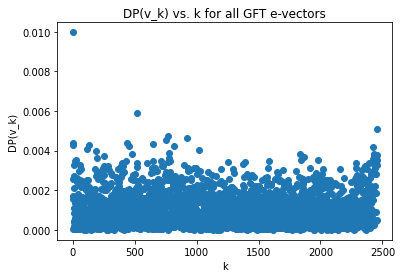

In [8]:
plt.scatter(range(DP.shape[0]), DP)
plt.xlabel('k')
plt.ylabel('DP(v_k)')
plt.title('DP(v_k) vs. k for all GFT e-vectors');

## b) kNN classifier

In [9]:
def knn(X, y, k_all):
    """
    Computes the leave-one-out CV accuracy using kNN, for multiple values of k.

    X: signals, with shape (n_features, n_samples)
    y: labels vector
    k_all: the values of k to try for kNN
    """
    # compute pairwise distances between column samples
    dists = np.zeros((X.shape[1], X.shape[1])) # dists[i][j] = distance between samples i and j
    
    for i in range(X.shape[1]):
        for j in range(i+1, X.shape[1]):
            dist = np.linalg.norm(X[:, i] - X[:, j])
            dists[i, j] = dist
            dists[j, i] = dist
    
    # neighbors of each sample, ordered by increasing distance
    nns = dists.argsort(axis=1)[:, 1:]

    row_idx = np.arange(len(dists)).reshape((len(dists), 1))

    # classes of nearest neighbors
    y_nns = y[nns][:, :, 0]

    k_all = [3, 5, 7]

    for k in k_all:
        # get most common class from each sample's kNNs
        preds = y_nns[:, :k].mean(axis=1) >= 1.5 # True = class 2, False = class 1
        print('\tAccuracy for k = {}: {}'.format(k, (preds == (y - 1)).mean()))

In [10]:
print('Using all frequencies:')
knn(X, y, [3, 5, 7])

Using all frequencies:
	Accuracy for k = 3: 0.7111111111111111
	Accuracy for k = 5: 0.7348611111111111
	Accuracy for k = 7: 0.76125


## c) Filtering almost all frequencies

In [11]:
def filter_gft(X_gft, k_idxs, keep_ratio):
    """
    Filters the GFT of a signal matrix to preserve only the top keep_ratio frequencies,
        as ordered by k_idxs
    
    X_gft: the GFT of signal matrix X
    k_idxs: priority order with which to keep frequencies
    keep_ratio: ratio of frequency coefficients to preserve in the signal GFT

    Returns X_gft, but with coefficients for frequencies outside the top keep_ratio set to 0
    """
    
    n_keep = int(len(k_idxs) * keep_ratio)
    k_top = k_idxs[:n_keep]
    print('\tKept {} frequencies'.format(n_keep))
    
    # select frequencies to preserve
    X_gft_f = np.zeros(X_gft.shape)
    X_gft_f[k_top, :] = X_gft[k_top, :]

    return X_gft_f

In [12]:
def filtered_knn(X_gft, y, k_idxs, keep_ratio, n_nbrs_all):
    """
    Filters the GFT of a signal matrix, then evaluates classification accuracy using kNN

    X_gft: the GFT of signal matrix X
    y: labels vector
    k_idxs: priority order with which to keep frequencies
    keep_ratio: ratio of frequency coefficients to preserve in the signal GFT
    n_nbrs_all: the different values of k to try for kNN
    """

    # preserve only values at the top frequency
    X_gft_f = filter_gft(X_gft, k_idxs, keep_ratio)
    
    # take iGFT of filtered signal
    X_f = V @ X_gft_f
    
    # kNN
    knn(X_f, y, n_nbrs_all)

In [13]:
# order frequencies by DP
k_idxs = np.argsort(DP)[::-1]
print('k = {} maximizes distinguishing power'.format(k_idxs[0]))

# try kNN, keeping only the top frequency
filtered_knn(X_gft, y, k_idxs, 1 / len(k_idxs), [3, 5, 7])

k = 2 maximizes distinguishing power
	Kept 1 frequencies
	Accuracy for k = 3: 0.6952777777777778
	Accuracy for k = 5: 0.6979166666666666
	Accuracy for k = 7: 0.7111111111111111


In [16]:
# try kNN, with other values of p
p_all = [0.75, 0.8, 0.85, 0.9, 0.95]

for p in p_all[::-1]:
    print('With top {} of frequencies (p = {}):'.format(np.round(1 - p, decimals=2), p))
    filtered_knn(X_gft, y, k_idxs, 1 - p, [3, 5, 7])

With top 0.05 of frequencies (p = 0.95):
	Kept 122 frequencies
	Accuracy for k = 3: 0.6820833333333334
	Accuracy for k = 5: 0.6847222222222222
	Accuracy for k = 7: 0.6847222222222222
With top 0.1 of frequencies (p = 0.9):
	Kept 245 frequencies
	Accuracy for k = 3: 0.6847222222222222
	Accuracy for k = 5: 0.6820833333333334
	Accuracy for k = 7: 0.6794444444444444
With top 0.15 of frequencies (p = 0.85):
	Kept 368 frequencies
	Accuracy for k = 3: 0.6952777777777778
	Accuracy for k = 5: 0.6952777777777778
	Accuracy for k = 7: 0.69
With top 0.2 of frequencies (p = 0.8):
	Kept 491 frequencies
	Accuracy for k = 3: 0.6979166666666666
	Accuracy for k = 5: 0.6926388888888889
	Accuracy for k = 7: 0.6873611111111111
With top 0.25 of frequencies (p = 0.75):
	Kept 614 frequencies
	Accuracy for k = 3: 0.6926388888888889
	Accuracy for k = 5: 0.6926388888888889
	Accuracy for k = 7: 0.6926388888888889
